# Mean radius and sizes thresholds calculation

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import yaml

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, peak_widths


from endoanalysis.nucprop import visualize_masks
from endoanalysis.datasets import MasksDataset, parse_master_yaml
from endoanalysis.utils import load_masks_areas, decorate_areas_distr

In [2]:
IMGS_DIR = "figs"
YAML_PATH = "../data/masks/masks_raw/unique_with_masks.yml"

Cheking the imported masks

In [3]:
lists = parse_master_yaml(YAML_PATH)
dataset = MasksDataset(lists["images_lists"], lists["masks_lists"])

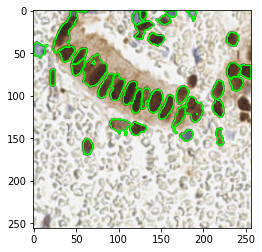

In [4]:
dataset.visualize(0)

Importing the masks

In [5]:
mask_areas = load_masks_areas(dataset.masks_paths)

Loading mask areas: 100%|██████████| 1780/1780 [00:34<00:00, 51.29it/s]

Done!


The raw distribution

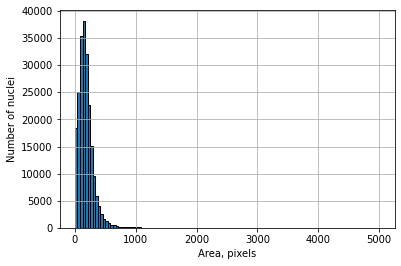

In [6]:
fig, ax = plt.subplots()
_ = ax.hist(mask_areas, bins="rice", edgecolor="black")
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)

It seems that there are some outliers in the right tail. Let's take a closer look:


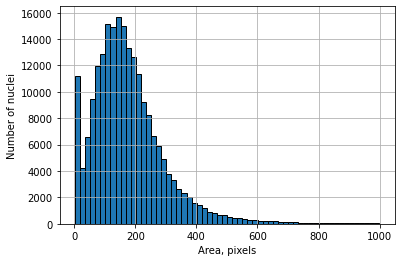

In [7]:
cut_value = 1000
mask_areas_cut = mask_areas[mask_areas<cut_value]

fig, ax = plt.subplots()
_, bins = np.histogram(mask_areas_cut, bins="rice")
hist, bins, _ = ax.hist(mask_areas_cut, edgecolor='black', bins=int(len(bins)/2))
bin_width = bins[1] - bins[0]
kde = gaussian_filter1d(hist, sigma=bin_width/16)
centers = (bins[1:] + bins[:-1]) / 2
peaks = find_peaks(kde)[0]
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)



We can see, that there are also outliers at smal area values. We treat big and small outliers separately

Main peak is at 143 pixels.


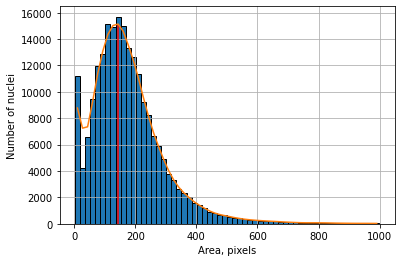

In [8]:
peaks = find_peaks(kde)[0]
main_peak_bin_id = peaks[0]
main_peak = centers[main_peak_bin_id]
fig, ax = plt.subplots()
_, bins = np.histogram(mask_areas_cut, bins="rice")
hist, bins, _ = ax.hist(mask_areas_cut, edgecolor='black', bins=int(len(bins)/2))
ax.plot(centers, kde)
ax.vlines(centers[main_peak_bin_id], 0, kde[main_peak_bin_id], colors=["r"])
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)
print("Main peak is at %i pixels."%main_peak)

Now lets set the threshold for outliers with big areas. We define it as 0.99 right quantile (stating from the main peak):

In [9]:
fraction = 0.99
size = 100
hist_right = hist[main_peak_bin_id:]
bins_right = bins[main_peak_bin_id:]
integral = np.sum(np.tril(np.repeat(hist_right.reshape(1,-1), size,axis=0)), axis=1)
full_integral = integral[-1]
thresh_bin_id = np.min(np.where(integral > full_integral * fraction)[0])
thresh_big = bins_right[thresh_bin_id]
print("The threshold for outliers with big areas is %1.2f pixels."%np.round(thresh_big))


The threshold for outliers with big ares is 667.00 pixels.


Now lets find the thresh for small outliers. To do so, we find the histogram only up to a main peak, evaluate the propapility density again and find the postion of the well at the left:

The threshold for small outliers is 18.00 pixels.


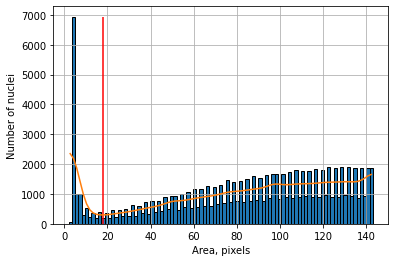

In [10]:
fig, ax = plt.subplots()
mask_areas_left = mask_areas[mask_areas<main_peak]
_, bins = np.histogram(mask_areas_left, bins="rice")
hist_left, bins_left, _ = ax.hist(mask_areas_left, edgecolor='black', bins=int(len(bins)))
# hist_left, bins_left, _ = ax.hist(mask_areas[mask_areas<main_peak], edgecolor='black', bins="rice")
kde = gaussian_filter1d(hist_left, sigma=bin_width/8)
centers = (bins_left[1:] + bins_left[:-1]) / 2
wells= find_peaks(-kde)[0]
thresh_small = centers[(wells).astype(int)][0]
ax.plot(centers, kde)
ax.vlines([thresh_small], 0, max(hist_left), colors=["r"])
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)

print("The threshold for small outliers is %1.2f pixels."%np.round(thresh_small))

Now we can cut off the outliers and look at the final distribution

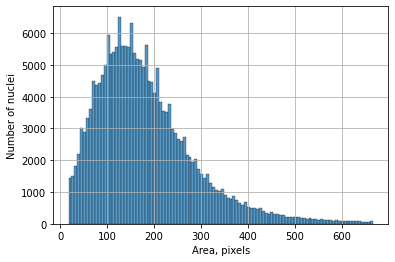

In [11]:
valid_ids = (mask_areas < thresh_big) * (mask_areas > thresh_small)
mask_areas_filtered = mask_areas[valid_ids]
fig, ax = plt.subplots()
sns.histplot(mask_areas_filtered, bins="scott",ax=ax)
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)

Makes sence to try other heuristics for bin width:

In [12]:
def pixels_to_mkm(x, tile_pixels_size=256, tile_phys_size = 100):
    return x * tile_phys_size / tile_pixels_size

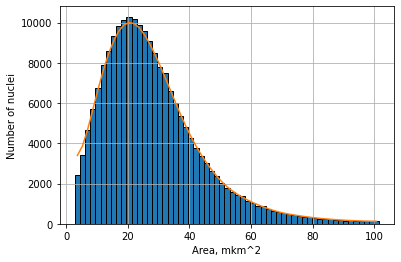

In [13]:
fig, ax = plt.subplots()
mask_areas_filtered_sqmkm = np.apply_along_axis(lambda x: pixels_to_mkm(pixels_to_mkm(x)), 0, mask_areas_filtered)
_, bins = np.histogram(mask_areas_filtered_sqmkm, bins="rice")
hist, bins, _ = ax.hist(mask_areas_filtered_sqmkm, bins=int(len(bins)/2), edgecolor="black")
bin_width = bins[1] - bins[0]
kde = gaussian_filter1d(hist, sigma=bin_width)
centers = (bins[1:] + bins[:-1]) / 2
ax.plot(centers, kde)
decorate_areas_distr(
    fig, 
    ax, 
    xlabel="Area, pixels", 
    ylabel="Number of nuclei"
)
ax.set_xlabel("Area, mkm^2")
fig.savefig(os.path.join(IMGS_DIR, "final_areas_distr"), dpi=300)

Now we find a mean area and estimate the mean squire radius

In [14]:
mean_area = np.mean(mask_areas_filtered)
mean_raiduis = np.sqrt(mean_area / np.pi)
print("The mean nuclei area is %1.2f"%mean_area)
print("The mean square radius is %1.2f"%mean_raiduis)

The mean nuclei area is 182.52
The mean square radius is 7.62
